In [2]:
%load_ext autoreload
%autoreload 2

In [99]:
import numpy as np
import sktime
import matplotlib.pyplot as plt 
import torch
from pathlib import Path
import seaborn as sns

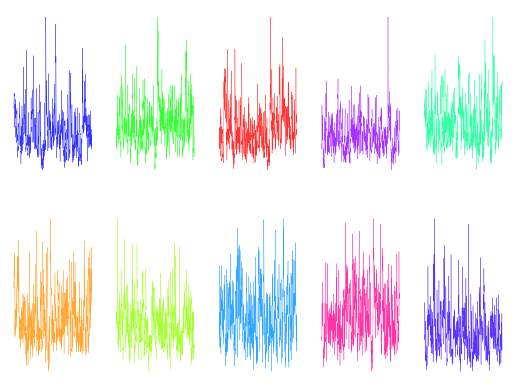

In [172]:
path = Path("/Users/mds8301/Desktop/temp/dopamine_full_timeseries_array.pt")
data = torch.load(path)

data = data[~torch.isnan(data[:, 0])]

features = data[:, 1:].detach().numpy()
labels = data[:, 0]

ds = features[:,:1500000][:,::10]


ds = ds.reshape(-1, 10000)

ax_labels = ['A', 'B', 'C', 'D', 'E', 'F','G','H','I','J']

colors = [
    '#FF5733',
    '#33FF57',
    '#5733FF',
    '#FF33A6',
    '#33A6FF',
    '#A6FF33',
    '#FFA633',
    '#33FFA6',
    '#A633FF',
    '#FF3333',
    '#33FF33',
    '#3333FF'
]
fig, ax = plt.subplot_mosaic(mosaic = """ 
                             ABCDE
                             FGHIJ
                             """)


for i, lab in enumerate(ax_labels):
    c = colors.pop()
    ax[lab].plot(ds[i], lw=0.25, color = c)
    ax[lab].axis('off')
    sns.despine(ax = ax[lab])
    

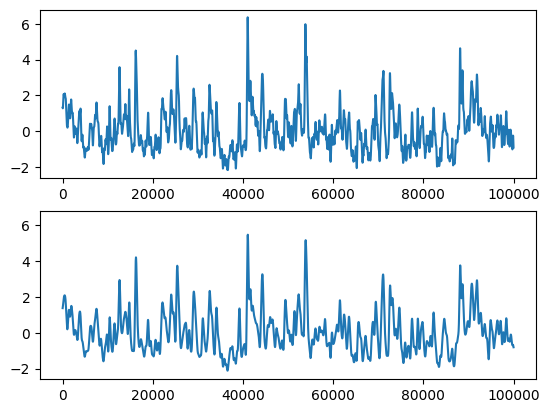

In [221]:
from scipy import signal
import numpy as np

# Generate a noisy signal

# Define the filter parameters
order = 3
cutoff = 5

# Create the filter
b, a = signal.butter(order,Wn=2, btype='low',fs =  1.0173E03, analog=False)

# Apply the filter
y = signal.filtfilt(b, a, features[0])
fig, ax = plt.subplots(nrows = 2, sharey=True)

ax[0].plot(features[0][:100000])
ax[1].plot(y[:100000])

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_42295/1745403518.py:1: DeprecationWarning: scipy.signal.cwt is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  waves = signal.cwt(features[0], signal.ricker, widths=[10130])


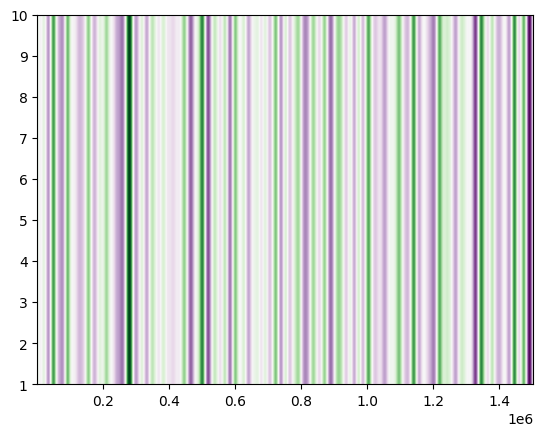

In [266]:
waves = signal.cwt(features[0], signal.ricker, widths=[10130])
waves
plt.imshow(waves, extent=[1, features[0].shape[0], 1, 10], 
           vmax = abs(waves).max(), 
           vmin = -abs(waves).max(), 
           aspect = 'auto', 
           cmap = "PRGn")

/var/folders/_3/4x4mtlsd3n37vfrcjmsz1vcd8clmkl/T/ipykernel_42295/1450042251.py:1: DeprecationWarning: scipy.signal.ricker is deprecated in SciPy 1.12 and will be removed
in SciPy 1.15. We recommend using PyWavelets instead.

  plt.plot(signal.ricker(features[0].shape[0], 600))


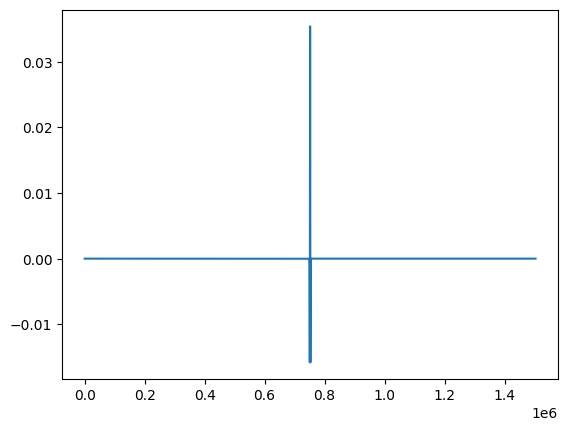

In [278]:
plt.plot(signal.ricker(features[0].shape[0], 600))

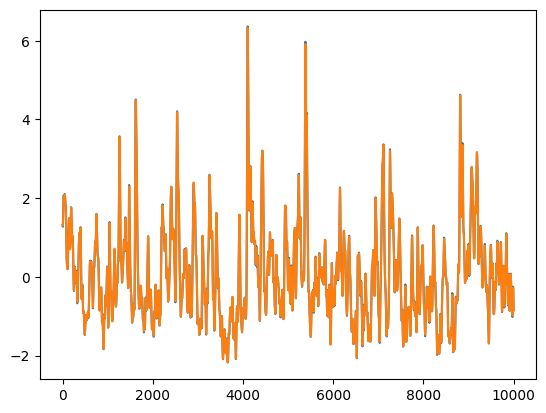

In [124]:
ft_features

array([[ 99.80345221],
       [110.21171192],
       [ 50.38804459],
       ...,
       [ 38.87920632],
       [ 17.5014439 ],
       [ 17.28811508]])

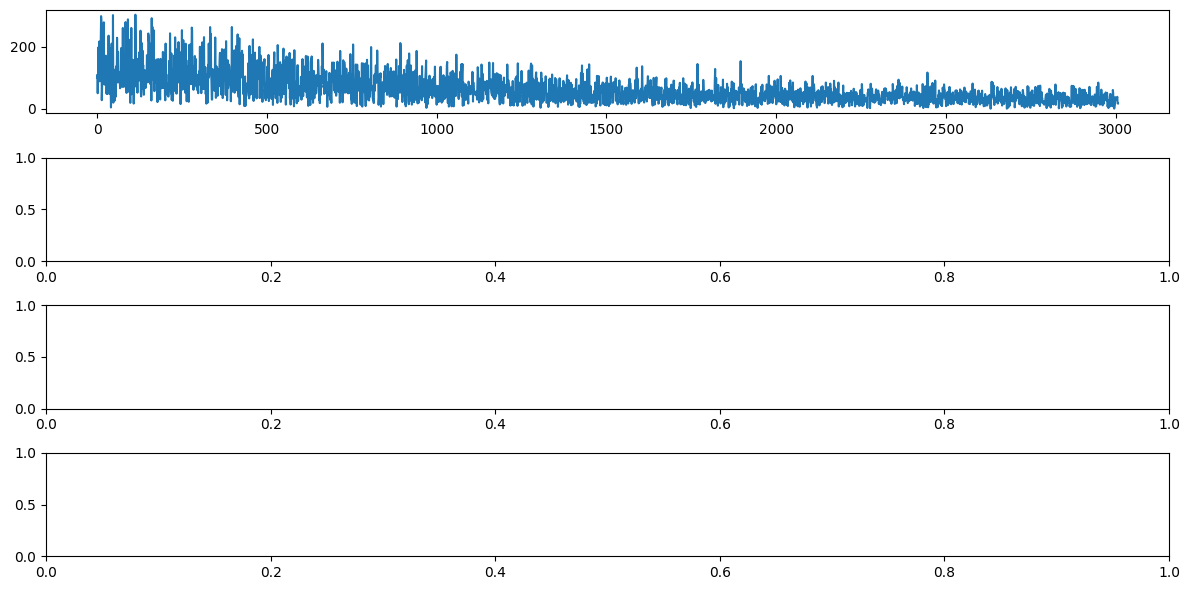

In [125]:
fig, ax = plt.subplots(nrows = 4, figsize = (12,6))
ax[0].plot(ft_features)
plt.tight_layout()

In [98]:
from sktime.clustering.k_means import TimeSeriesKMeans
cluster = TimeSeriesKMeans(n_clusters =10)
cluster.fit(ds)

KeyboardInterrupt: 

In [ ]:
labels = cluster

In [240]:
def z_score(dataset: np.ndarray) -> np.ndarray:
    """
    Apply z-score normalization to the array.

    Args:
        dataset (np.ndarray): The input dataset.

    Returns:
        np.ndarray: The normalized dataset.
    """
    mean = np.mean(dataset, axis=0, keepdims=True)
    std = np.std(dataset, axis=0, keepdims=True)
    return (dataset - mean) / std

def generate_sequence(subsequence_type) -> np.ndarray:

    """
    Generate a synthetic time series sequence. of length 5000
    injects random sine, square and saw tooth waves into the sequence and applies gaussian noise

    Returns:
        np.ndarray: The generated time series sequence.
    """
    sequence_length = 500
    subsequence_length = np.random.randint(
        5, 25
    )  # Randomly generate the subsequence length
    num_subsequences = np.random.randint(
        5,30 
    )  # Randomly generate the number of subsequences

    # Generate the sine wave subsequence
    sine_wave = np.sin(
        np.linspace(0, np.random.randint(1, 10) * np.pi, subsequence_length)
    )

    # Generate the square wave subsequence
    square_wave = np.sign(
        np.sin(np.linspace(0, np.random.randint(1, 10) * np.pi, subsequence_length))
    )

    # Generate the saw tooth wave subsequence
    saw_tooth_wave = np.cumsum(np.random.uniform(-1, 1, subsequence_length))

    # Initialize the main sequence
    main_sequence = np.zeros(sequence_length)

    # Randomly insert the subsequences into the main sequence
    for _ in range(num_subsequences):

        if subsequence_type == "sine":
            subsequence = sine_wave
        elif subsequence_type == "square":
            subsequence = square_wave
        else:
            subsequence = saw_tooth_wave

        start_index = np.random.randint(
            0, sequence_length - subsequence_length
        )  # Randomly choose the start index
        main_sequence[start_index : start_index + subsequence_length] += subsequence

    # Add Gaussian noise to the main sequence
    main_sequence += np.random.normal(0, 0.01, sequence_length)
    return z_score(main_sequence.astype(np.float32))


def generate_dataset(subsequence_type, numb_samples: int = 100_000, ) -> np.ndarray:
    """
    Generate a synthetic dataset with multiple time series sequences.

    Args:
        numb_samples (int, optional): The number of time series sequences to generate. Defaults to 10000.

    Returns:
        np.ndarray: The generated dataset.
    """
    dataset = np.array([generate_sequence(subsequence_type) for _ in range(numb_samples)])
    return dataset
sine_waves = generate_dataset('sine', 500)
saw_tooths = generate_dataset('saw_tooth', 500)
square_waves = generate_dataset('square', 500)

In [241]:
data = np.concatenate([sine_waves, square_waves, saw_tooths], axis=0)
data

array([[-7.9228401e-02, -9.0494916e-02,  1.6773267e+00, ...,
        -7.3924869e-02, -1.1547284e-01, -7.1229234e-02],
       [-1.2512335e-03,  1.6899114e-02,  5.8635224e-02, ...,
         2.2412645e-02,  1.5862614e-02,  1.0371669e-01],
       [-1.1481140e+00, -1.1166031e+00, -1.1340954e+00, ...,
        -1.1453191e+00, -1.1289996e+00, -1.1458062e+00],
       ...,
       [-3.8180920e-01, -4.0292770e-01, -3.8230985e-01, ...,
        -4.0157390e-01, -3.8463551e-01, -3.9205772e-01],
       [-3.1237310e-01, -2.5731346e-01, -3.1458217e-01, ...,
        -3.3150193e-01, -3.0759862e-01, -3.2284117e-01],
       [ 5.6920648e-01,  5.6462735e-01,  6.1223620e-01, ...,
         6.1202216e-01,  5.9246165e-01,  5.9550393e-01]], dtype=float32)

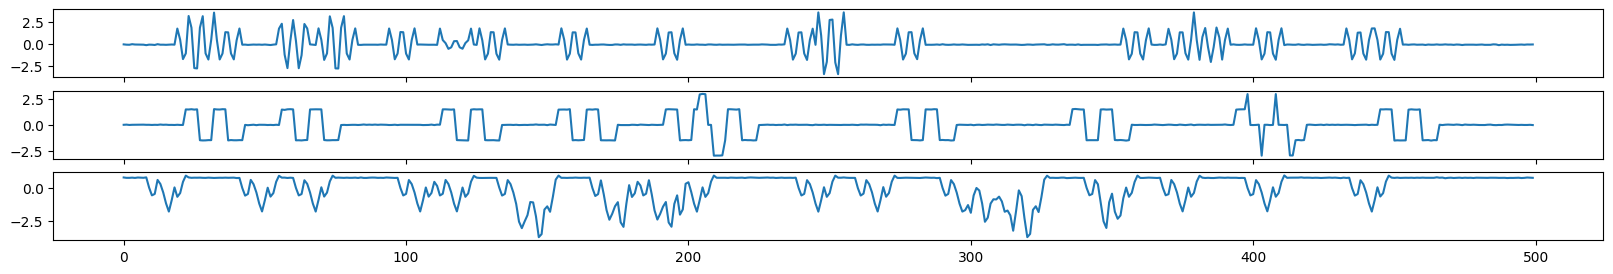

In [242]:
fig, ax = plt.subplot_mosaic(mosaic="""
                             AAA
                             BBB
                             CCC
                             """, figsize = (20, 3), sharex=True)
ax['A'].plot(data[np.random.randint(0,500)])
ax['B'].plot(data[np.random.randint(500, 1000)])
ax['C'].plot(data[np.random.randint(1000,1500)])


In [6]:
from sktime.annotation.clasp import ClaSPSegmentation, find_dominant_window_sizes

In [13]:
period_size = find_dominant_window_sizes(sine_waves[10])
period_size
clasp = ClaSPSegmentation(period_length=period_size, n_cps = 5, fmt = "sparse")

found_cps = clasp.fit_predict(sine_waves[0])
profiles = clasp.profiles
scores = clasp.scores

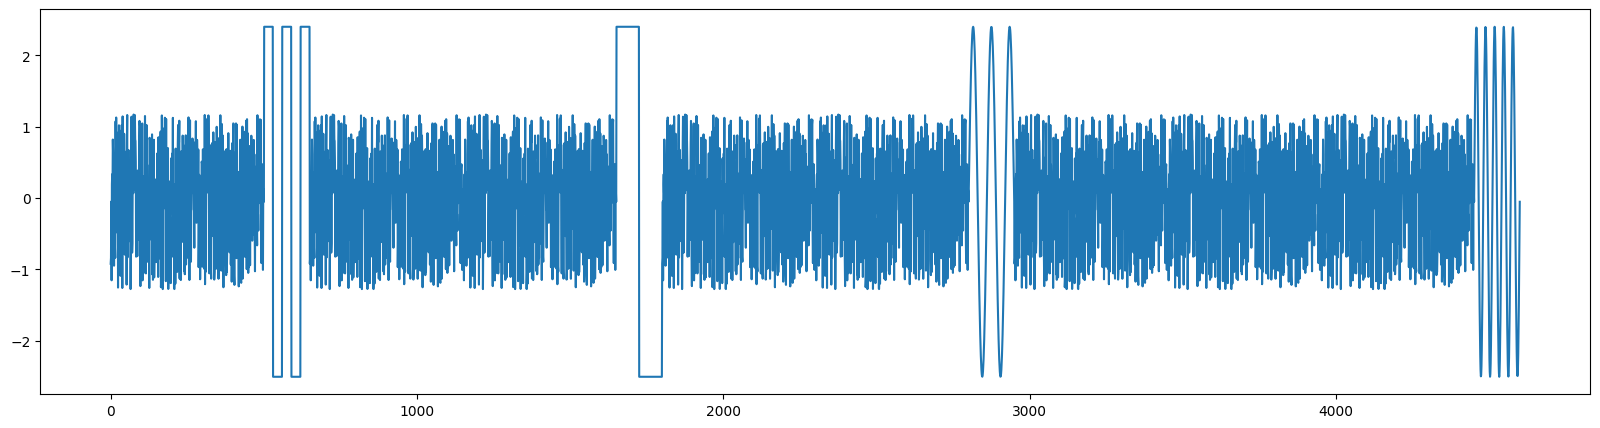

In [184]:
# Define the three sequences
sin = np.sin(np.linspace(0, 5 * np.pi,150))
sin_2 = np.sin(np.linspace(0, 10* np.pi,150))
square = np.sign(
        np.sin(np.linspace(0, 5 * np.pi, 150)))
square_2 = np.sign(
        np.sin(np.linspace(0, 2 * np.pi, 150)))



noise = np.random.uniform(-.5, .5, 500)
# Scale the data to range from -1 to 1
# noise = 2 * (noise - np.min(noise)) / (np.max(noise) - np.min(noise)) - 1


data = z_score(np.concatenate([noise, square, noise, noise, square_2, noise, noise, sin, noise, noise, noise, sin_2]))
fig, ax= plt.subplots(figsize = (20,5))
ax.plot(data)


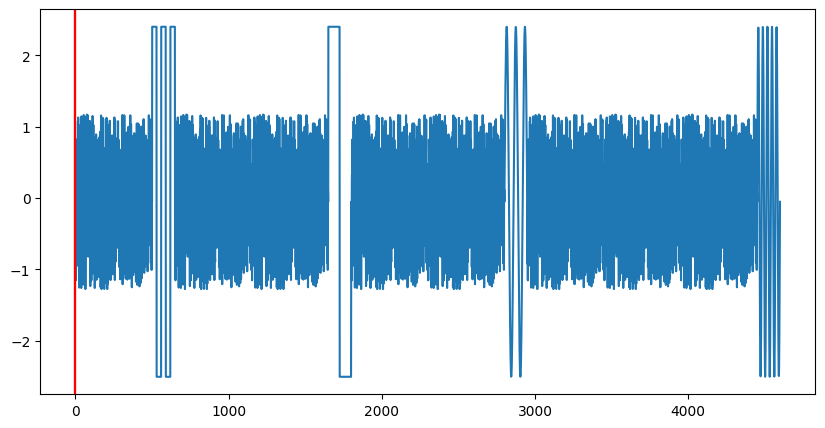

In [239]:
period_size = find_dominant_window_sizes(data)
period_size
clasp = ClaSPSegmentation(period_length=2, n_cps = 4, exclusion_radius=.001)

found_cps = clasp.fit_predict(data)
profiles = clasp.profiles
scores = clasp.scores
fig, ax = plt.subplots(nrows = 1, figsize = (10,5))
ax.plot(data) 
for i in found_cps:
    ax.axvline(x = i, color = 'red')

AttributeError: 'ClaSPSegmentation' object has no attribute 'change_points_to_segments'

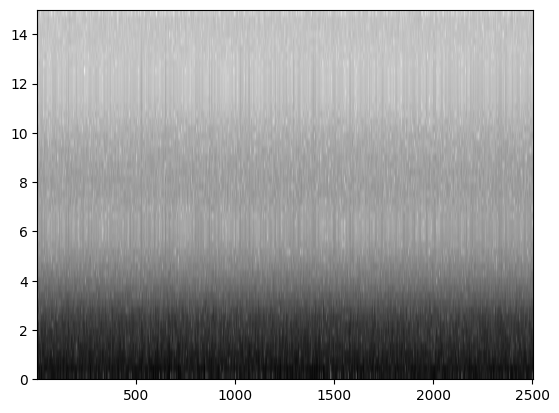

In [127]:
# for i in range(ds_data.shape[0]):

plt.specgram(ds_data[2], NFFT = 100, Fs = 30, noverlap=5, cmap='Greys')
plt.show()

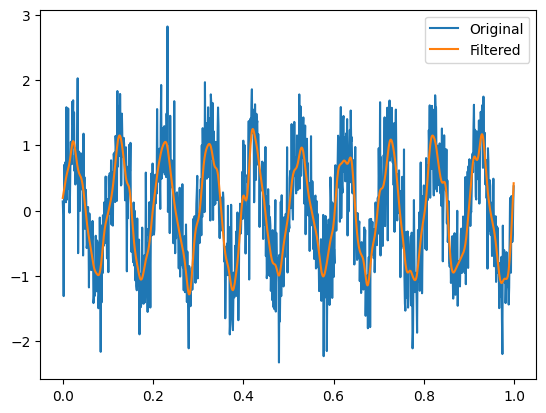